# Word2Vec for The ONS 
The purpose of this notebook is to demonstrate how we can use [word2vec](https://www.tensorflow.org/tutorials/word2vec) to bridge the gap between the way the ONS and the general public communicate. This is a common problem seen when users search the website for terms such as 'murder', as the ONS publishes such content under the more professional term 'homicide'.

By using training data such as the Google News vocabulary dataset, we can train models to understand the relationship between words in a 300-dimensional vector space, where similar words occupy the same part of this vector space. Here, we use a slimlined version of the Google News dataset for English words only, and import the data using the gensim python module as below:

In [69]:
import gensim

fname = "/Users/sullid/ONS/dp-search-service/src/main/resources/vectorModels/GoogleNews-vectors-negative300-SLIM.bin"
google_model = gensim.models.KeyedVectors.load_word2vec_format(fname, binary=True)

# Interesting Properties
The above model has been trained using a neural network, which is able to capture many interesring linguistic regularities and patterns. Interestingly, many such patters can be expressed as linear combinations of these vectors. For example:

In [70]:
madrid = google_model.word_vec("Madrid")
spain = google_model.word_vec("Spain")
france = google_model.word_vec("France")

vector = madrid - spain + france
similar_to_vector = google_model.similar_by_vector(vector)
most_similar_word = similar_to_vector[0]
print most_similar_word

(u'Paris', 0.7502284646034241)


The linear combination vec("Madrid") - vec("Spain") + vec("France") is closer to vec("Paris") than any other word vector, meaning the neural network is able to learn the relationship between capital cities and their host countries, without any such knowledge *a priori*.

# Application to ONS Search Terms
The next step is to define a set of phrases which are commonly used to search on the ONS website. The below list of 17 words correspond to some of the most popular search terms as recorded by Google Analytics just before Christmas. For each term, we use word2vec to get the 20 most similar words, or the nearst 20 neighbours in our vector space, and append them to a list.

In [71]:
# Collect the word vectors
import numpy as np

searchTerms = ["gender pay gap", "cpi", "gdp", "inflation", "crime", "unemployment", 
              "population", "immigration", "mental health", "london", "life expectancy",
              "obesity", "religion", "migration", "poverty", "social media", "employment"]

def getVectorsAndWords(term, topn=1000):
    vectors = []
    terms = []
    
    vec = None
    # If multiple terms, combine linearly
    if (len(term.split(" ")) > 1):
        parts = term.split(" ")
        vec = np.array([google_model.wv[w] for w in parts]).sum(axis=0)
    else:
        vec = google_model.word_vec(term)
    
    vectors.append(vec)
    terms.append(term)
    
    # Add similar words
    for word,score in google_model.similar_by_vector(vec, topn=topn):
        if (score > 0.25 and word not in words):
            vec = google_model.word_vec(word)
            vectors.append(vec)
            terms.append(word)
            
    return vectors, terms

In [72]:
topn = 15
word_vectors = []
words = []
for searchTerm in searchTerms:
    try:
        vectors, terms = getVectorsAndWords(searchTerm, topn=topn)
        word_vectors.extend(vectors)
        words.extend(terms)
    except KeyError:
        pass
word_vectors = np.array(word_vectors)

# word_vectors = model.wv.syn0
n_words = word_vectors.shape[0]
vec_size = word_vectors.shape[1]

In [73]:
print "Got %d words in total" % (n_words)

Got 261 words in total


# PCA
In order to visualise the relationship between this set of words, we have to reduce our 300 dimensional vector space down to the two or three dimensions we are typically use to visualizing. To do this, we use a technique called *Principal Component Analysis*, or *PCA*. This is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. It should be noted, that the definition of each principal component is not (and need not be) necessarily well understood, as each component can in principle describe the relationship between many others. Below, we compute the first 3 principal components of our 300-dimensional vector space:

In [74]:
from sklearn import decomposition

dimensions=3
pca = decomposition.PCA(n_components=dimensions)
pca_fit = pca.fit(word_vectors)

vectors = pca_fit.transform(word_vectors)
print vectors.shape

(261, 3)


# Clustering
Now that we have reduced the dimensionality of our data, we can proceed to group words into *clusters* of similarity. As we don't know the number of such clustera *a priori*, we can use the *elbow* method to determine the minimum number of clusters present in our data, by plotting the number of clusters against the percentage of variance explained:

Performing K-Means...
Done
Computing Euclidean distances...
Done
Computing pairwise distances...
Computing percentage of variane explained...
Plotting...
Minimum number of clusters =  3


/Users/sullid/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning:

invalid value encountered in greater



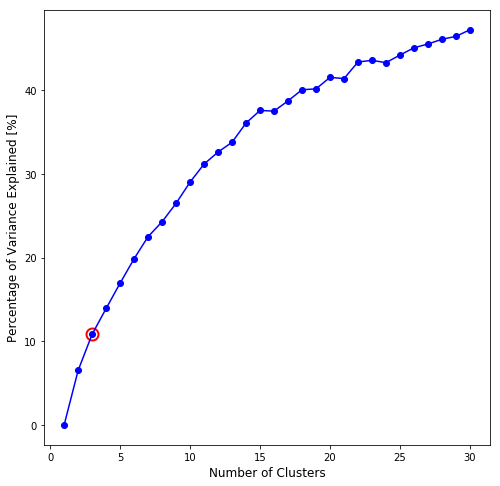

In [75]:
import matplotlib.pyplot as plt
import seaborn
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import fclusterdata

def eblow(data, n):
    print "Performing K-Means..."
    kMeansVar = [KMeans(n_clusters=k, random_state=0).fit(data) for k in range(1, n)]
    print "Done"
    centroids = [X.cluster_centers_ for X in kMeansVar]
    print "Computing Euclidean distances..."
    k_euclid = [cdist(data, cent) for cent in centroids]
    dist = [np.min(ke, axis=1) for ke in k_euclid]
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    print "Done"
    wcss = [sum(d**2) for d in dist]
    print "Computing pairwise distances..."
    pair_dist = pdist(data)
    print "Computing percentage of variane explained..."
    tss = sum(pair_dist**2)/data.shape[0]
    bss = tss - wcss
    percentage_variance = (bss/tss)*100.0
    
    K = range(1,n)
    seg_threshold = 0.95 #Set this to your desired target

    #The angle between three points
    def segments_gain(p1, v, p2):
        vp1 = np.linalg.norm(p1 - v)
        vp2 = np.linalg.norm(p2 - v)
        p1p2 = np.linalg.norm(p1 - p2)
        return np.arccos((vp1**2 + vp2**2 - p1p2**2) / (2 * vp1 * vp2)) / np.pi

    #Normalize the data
    criterion = np.array(avgWithinSS)
    criterion = (criterion - criterion.min()) / (criterion.max() - criterion.min())

    #Compute the angles
    seg_gains = np.array([0, ] + [segments_gain(*
            [np.array([K[j], criterion[j]]) for j in range(i-1, i+2)]
        ) for i in range(len(K) - 2)] + [np.nan, ])

    #Get the first index satisfying the threshold
    kIdx = np.argmax(seg_gains > seg_threshold)
    
    print "Plotting..."
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(K[kIdx], percentage_variance[kIdx], marker='o', markersize=12, 
        markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    
    ax.scatter(K, percentage_variance, color='b')
    ax.plot(K, percentage_variance, color='b')
    
    ax.set_xlabel("Number of Clusters", fontsize=12)
    ax.set_ylabel("Percentage of Variance Explained [%]", fontsize=12)
    
    print "Minimum number of clusters = ", K[kIdx]
    
    return kMeansVar
    
kMeansVar = eblow(word_vectors, 31)
plt.show()

# Visualization
To visualize the data in a way that humans can understand, we perform *PCA* with 3 dimensions, and plot the reslting words in this reduced 3 dimensional vector space. We use colour to distinguish different clusters from one another.

In [76]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    
    for k in range(pl_entries):
        C = map(np.uint8, np.array(cmap(k*h)[:3])*255)
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        
    return pl_colorscale

def ncols(NUM_COLORS):
    import matplotlib.cm as mplcm
    import matplotlib.colors as colors
    
    cm = plt.get_cmap('gist_rainbow')
    cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
    return scalarMap

In [77]:
fig = tools.make_subplots(rows=1, cols=1,
                          print_grid=False,
                          specs=[[{'is_3d': True}]])
scene = dict(
    camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=2.5, y=0.1, z=0.1)
    ),
    xaxis=dict(title='pc1',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    ),
    yaxis=dict(title='pc2',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    ),
    zaxis=dict(title='pc3',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    )
)

kOpt = 25
pca3 = decomposition.PCA(n_components=3)
pca_fit3 = pca3.fit(word_vectors)
X = pca_fit3.transform(word_vectors)

name,est = ('k_means', KMeans(n_clusters=kOpt, random_state=0).fit(word_vectors))
vector_idx = est.fit_predict(word_vectors)

# cols = ncols(kOpt+1, cmap="Paired")
NUM_COLORS = kOpt+1
scalarMap = ncols(NUM_COLORS)
cols = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]
for icluster in range(kOpt):
    idx = np.where(vector_idx == icluster)[0]
    labels = est.labels_[idx]
    data = X[idx]

    text = [words[ix] for ix in idx]
    pcols = [cols[icluster]] * len(idx)

    trace = go.Scatter3d(x=data[:, 0], y=data[:, 1], z=data[:, 2],
                         name="Cluster %d" % (icluster + 1),
                         text=text,
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                color=pcols[:],
                                line=dict(color='black', width=1)
        ))
    fig.append_trace(trace, 1, 1)

# Add cluster centroids
centroids = pca_fit3.transform(est.cluster_centers_)
centroidNames = ["Centroid %d" % (i+1) for i in range(kOpt)]
centroidsTrace = go.Scatter3d(x=centroids[:, 0], y=centroids[:, 1], z=centroids[:, 2],
                     name="Centroid",
                     text=centroidNames[:],
                     showlegend=False,
                     mode='markers',
                     marker=dict(
                            color="black",
                            line=dict(color='black', width=1)
    ))
fig.append_trace(centroidsTrace, 1, 1)

fig['layout'].update(height=900, width=900,
                     margin=dict(l=10,r=10))

fig['layout']['scene1'].update(scene)
fig['layout']['scene2'].update(scene)
fig['layout']['scene3'].update(scene)
fig['layout']['scene4'].update(scene)
fig['layout']['scene5'].update(scene)

# Use py.iplot() for IPython notebook
py.iplot(fig, filename='3d point clustering')

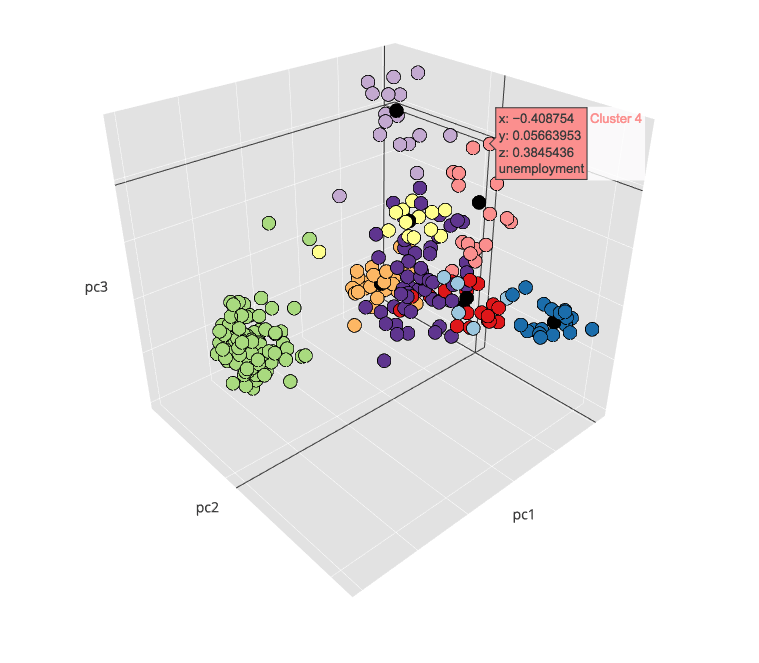

In [78]:
from IPython.display import Image
Image(filename='plots/clusters.png')

# FInal Remarks and Future Direction
We have used [word2vec](https://www.tensorflow.org/tutorials/word2vec) and *PCA* in this example in order to visualize the data in a way humans are accustom to, however in practice this is not necesarry. In fact, in this example we performed the clustering of our data in the full 300 dimensional vector space, and only reduced the dimensionality of this data in order to visualize groups of similar words.

In the future, we can use articles published by ONS to train our own model. This model could learn over time based on the connections that users find while searching the website, for example, if a search for 'crime' often results in navigation to an article about 'homicide' then we can reinforce the vector between these words.

# Training a Model using ONS Data
By using the data indexed in Elasticsearch, we can build our own word2vec model based on actual ONS publications!

In [79]:
from modules.ONS import utils, queries

# Get an Elasticsearch (Http) client
client = utils.getSearchClient("http://localhost:9200", 10000)

In [80]:
# Execute a search scroll to get all pages

searchHits = client.search(
    index="ons*",
    scroll="2m",
    size=100,
    body=queries.matchAll
)
sid = searchHits["_scroll_id"]
scroll_size = searchHits["hits"]["total"]

pages = []
while scroll_size > 0:
    for searchHit in searchHits["hits"]["hits"]:
        pages.append(searchHit["_source"])
                
    searchHits = client.scroll(scroll_id=sid, scroll="2m")
    sid = searchHits["_scroll_id"]
    scroll_size = len(searchHits["hits"]["hits"])

print len(pages)

57278


In [81]:
# Gather some human written text into 'content'
from nltk.tokenize import sent_tokenize

fix_encoding = lambda s: s.decode('utf8', 'ignore')

from string import punctuation
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

content = []
for page in pages:
    if ("description" in page):
        desc = page["description"]
        text = ""
        if ("title" in desc):
            title = desc["title"]
            if (title.endswith(".") is False):
                title += ".\n"
            text += title
        if ("summary" in desc):
            text += desc["summary"] + "\n"
        if ("headline1" in desc):
            text += desc["headline1"] + "\n"
        if ("headline2" in desc):
            text+= desc["headline2"] + "\n"
        if ("headline3" in desc):
            text+= desc["headline3"] + "\n"
            
        sent_tokenize_list = sent_tokenize(text)
        for sentence in sent_tokenize_list:
            content.append(fix_encoding(sentence.encode("utf-8").strip()))
            
            
print len(content)

71657


In [109]:
# Clean up the data a bit and train the model

from nltk.corpus import stopwords
from string import ascii_lowercase
import pandas as pd
import gensim, os, re, pymongo, itertools, nltk, snowballstemmer
from collections import Counter
 
data = [{"text_data":s} for s in content]
data = pd.DataFrame(data) # each row is one document; the raw text of the document should be in the 'text_data' column
 
# initialize stemmer
stemmer = snowballstemmer.EnglishStemmer()
 
# grab stopword list, extend it a bit, and then turn it into a set for later
stop = stopwords.words('english')
stop.extend(['yr','main','known','may','also','zero','one','two','three','four','five','six','seven','eight','nine','ten','across','among','beside','however','yet','within']+list(ascii_lowercase))
stoplist = stemmer.stemWords(stop)
stoplist = set(stoplist)
stop = set(sorted(stop + list(stoplist))) 
 
# remove characters and stoplist words, then generate dictionary of unique words
data['text_data'].replace('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\]',' ',inplace=True,regex=True)
wordlist = filter(None, " ".join(list(set(list(itertools.chain(*data['text_data'].str.split(' ')))))).split(" "))
data['stemmed_text_data'] = [' '.join(filter(None,filter(lambda word: word not in stop and word in google_model.wv.vocab, line))) for line in data['text_data'].str.lower().str.split(' ')]
 
# remove all words that don't occur at least 5 times and then stem the resulting docs
minimum_count = 5
str_frequencies = pd.DataFrame(list(Counter(filter(None,list(itertools.chain(*data['stemmed_text_data'].str.split(' '))))).items()),columns=['word','count'])
low_frequency_words = set(str_frequencies[str_frequencies['count'] < minimum_count]['word'])
data['stemmed_text_data'] = [' '.join(filter(None,filter(lambda word: word not in low_frequency_words, line))) for line in data['stemmed_text_data'].str.split(' ')]
data['stemmed_text_data'] = [" ".join(re.sub('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\]',' ', next_text).split(' ')) for next_text in data['stemmed_text_data']]
 
# run word2vec model and then save it
params = {'size': 300, 'window': 10, 'min_count': 10, 
          'workers': 4, 'sample': 1E-3,}
texts_stemmed = filter(None, [next_text.strip(' ').split(' ') for next_text in data['stemmed_text_data']])
# texts_stemmed = [ [stemmer.stemWord(w) for w in line] for line in texts_stemmed ]

# Train the actual model
ons_model = gensim.models.Word2Vec(texts_stemmed, **params)
# Export the model
ons_model.wv.save_word2vec_format('./ons_w2v_model.bin.gz', binary=True)

In [113]:
# Load the model from disk
import gensim
ons_model = gensim.models.KeyedVectors.load_word2vec_format("./ons_w2v_model.bin.gz", binary=True)

ons_model.wv.similar_by_word(u'statistics')

[(u'official', 0.8183810710906982),
 (u'ons', 0.8116735816001892),
 (u'methodology', 0.7813386917114258),
 (u'releases', 0.7771118879318237),
 (u'key', 0.772800862789154),
 (u'review', 0.7724883556365967),
 (u'article', 0.772182822227478),
 (u'report', 0.770331084728241),
 (u'overview', 0.7640866041183472),
 (u'methods', 0.7511661648750305)]

# Cluster Keywords

In [100]:
# Cluster ONS keywords
import numpy as np

keywords = []
for page in pages:
    if ("description" in page):
        desc = page["description"]
        if ("keywords" in desc):
            keywords.extend(desc["keywords"])
        if ("title" in desc):
            # Split by whitespace and remove stop words
            title_tokens = [strip_punctuation(w) for w in desc["title"].split(" ") if w not in stop and w in google_model.wv.vocab]
            if (len(title_tokens) > 0):
                # Compute combined word vector
                vector = np.array([ons_model.wv[token.lower()] for token in title_tokens if token in ons_model.wv.vocab]).sum(axis=0)
                if (hasattr(vector, "__iter__") and len(vector) == 300):
                    word = ons_model.wv.similar_by_vector(vector, 1)[0][0]
                    if (len(word) > 2):
                        keywords.append( word )
print len(keywords)

50241


In [101]:
import numpy as np

def getVectorsAndWords(term, topn=1000):
    vectors = []
    terms = []
    
    vec = None
    # If multiple terms, combine linearly
    if (len(term.split(" ")) > 1):
        parts = term.split(" ")
        vec = np.array([ons_model.wv[w] for w in parts]).sum(axis=0)
    else:
        vec = ons_model.wv[term]
    
    vectors.append(vec)
    terms.append(term)
    
    # Add similar words
    for word,score in ons_model.wv.similar_by_vector(vec, topn=topn):
        if (score > 0.25 and word not in words):
            vec = model.wv[word]
            vectors.append(vec)
            terms.append(word)
            
    return vectors, terms    

In [102]:
topn = 10
word_vectors = []
words = []
for keyword in keywords:
    try:
        vectors, terms = getVectorsAndWords(keyword, topn=topn)
        word_vectors.extend(vectors)
        words.extend(terms)
    except KeyError:
        pass
word_vectors = np.array(word_vectors)

# word_vectors = model.wv.syn0
n_words = word_vectors.shape[0]
vec_size = word_vectors.shape[1]

print n_words

46201


Performing K-Means...
Done
Computing Euclidean distances...
Done
Computing pairwise distances...
Computing percentage of variane explained...


/Users/sullid/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning:

invalid value encountered in greater



Plotting...
Minimum number of clusters =  3


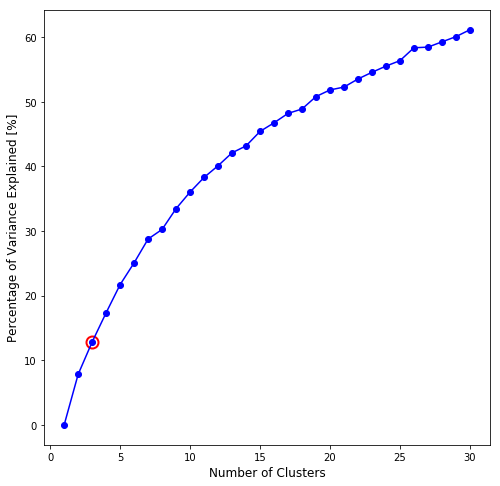

In [103]:
# Show elbow plot
kMeansVar = eblow(word_vectors, 31)
plt.show()

In [104]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    
    for k in range(pl_entries):
        C = map(np.uint8, np.array(cmap(k*h)[:3])*255)
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        
    return pl_colorscale

def ncols(NUM_COLORS, cmap='gist_rainbow'):
    import matplotlib.cm as mplcm
    import matplotlib.colors as colors
    
    cm = plt.get_cmap(cmap)
    cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
    return scalarMap

# Plotting
If the below plot isn't visible (if for example, you're viewing this on github) then click [here!](https://plot.ly/~Sully0190/6/cluster-1-cluster-2-cluster-3-cluster-4-cluster-5-cluster-6-cluster-7-cluster-8-/)

In [107]:
import matplotlib.pyplot as plt
import seaborn
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import fclusterdata
from sklearn import decomposition

kOpt = 30
pca3 = decomposition.PCA(n_components=3)
pca_fit3 = pca3.fit(word_vectors)
X = pca_fit3.transform(word_vectors)

NUM_COLORS = kOpt+1
scalarMap = ncols(NUM_COLORS, cmap="jet")

fig = tools.make_subplots(rows=1, cols=1,
                          print_grid=False,
                          specs=[[{'is_3d': True}]])
scene = dict(
    camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=2.5, y=0.1, z=0.1)
    ),
    xaxis=dict(title='pc1',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    ),
    yaxis=dict(title='pc2',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    ),
    zaxis=dict(title='pc3',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    )
)

name,est = ('k_means', KMeans(n_clusters=kOpt, random_state=0).fit(word_vectors))
vector_idx = est.fit_predict(word_vectors)

cols = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]
for icluster in range(kOpt):
    idx = np.where(vector_idx == icluster)[0]
    labels = est.labels_[idx]
    data = X[idx]

    text = [words[ix] for ix in idx]
    pcols = [cols[icluster]] * len(idx)

    trace = go.Scatter3d(x=data[:, 0], y=data[:, 1], z=data[:, 2],
                         name="Cluster %d" % (icluster + 1),
                         text=text,
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                color=pcols[:],
                                line=dict(color='black', width=1)
        ))
    fig.append_trace(trace, 1, 1)

# Add cluster centroids
centroids = pca_fit3.transform(est.cluster_centers_)
centroidNames = ["Centroid %d" % (i+1) for i in range(kOpt)]
centroidsTrace = go.Scatter3d(x=centroids[:, 0], y=centroids[:, 1], z=centroids[:, 2],
                     name="Centroid",
                     text=centroidNames[:],
                     showlegend=False,
                     mode='markers',
                     marker=dict(
                            color="black",
                            line=dict(color='black', width=1)
    ))
fig.append_trace(centroidsTrace, 1, 1)

fig['layout'].update(height=900, width=900,
                     margin=dict(l=10,r=10))

fig['layout']['scene1'].update(scene)
fig['layout']['scene2'].update(scene)
fig['layout']['scene3'].update(scene)
fig['layout']['scene4'].update(scene)
fig['layout']['scene5'].update(scene)

# Use py.iplot() for IPython notebook
py.iplot(fig, filename='3d ONS point clustering')